<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Advance%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [3]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
np.random.seed(59)

# Проверка гипотез, работа с данными

## Взгляд на данные

In [4]:
df = pd.read_csv('./data/prepared/train.csv')
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,staff,fixed,1,1,1,1,1,NaN,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,staff,fixed,1,1,1,1,1,приверять и принимать mr,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,staff,fixed,1,1,1,1,1,NaN,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,staff,fixed,1,1,1,1,1,NaN,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,staff,fixed,1,1,1,1,1,принимать mr,1,1


In [5]:
df_test = pd.read_csv('./data/prepared/test.csv')
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,...,staff,fixed,0,0,0,0,0,ресерч по rsync http losst ru rsync primery si...,8,1
1,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,...,staff,fixed,0,0,0,0,0,задача приостанавливать в связь с заморозка ра...,4,2
2,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,...,staff,fixed,0,0,0,0,0,задача закрывать в связь с передача проект,1,1
3,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,...,staff,fixed,0,0,0,0,0,не правильно реализовать логика вызов метод ge...,2,2
4,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,...,unknown,unknown,0,0,0,0,0,ch keneskhanova прежде все по проблема коррект...,7,2


In [6]:
df['text'] = df['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   project_id                  9589 non-null   int64  
 1   assignee_id                 9589 non-null   int64  
 2   creator_id                  9589 non-null   int64  
 3   month                       9589 non-null   int64  
 4   day                         9589 non-null   int64  
 5   hour                        9589 non-null   int64  
 6   minute                      9589 non-null   int64  
 7   key_name                    9589 non-null   object 
 8   key_num                     9589 non-null   int64  
 9   lemm_summary                9589 non-null   object 
 10  log_target                  9589 non-null   float64
 11  active                      9589 non-null   int64  
 12  position                    9589 non-null   object 
 13  hiring_type                 9589 

## Общий tf-idf

Попробуем выполнить общий tf-idf, с ограничением в N токенов, как для описания задачи, так и для комментариев

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

summ_tf_idf = TfidfVectorizer(stop_words=stopwords_all, max_features=3000)
comm_tf_idf = TfidfVectorizer(stop_words=stopwords_all, max_features=3000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
len_train, len_test = len(df), len(df_test)
len_train, len_test

(9589, 1070)

In [9]:
df_general = pd.concat([df, df_test], axis=0, ignore_index=True)
df_general.shape

(10659, 23)

In [10]:
df_general['lemm_summary'] = df_general['lemm_summary'].apply(lambda x: x[:100])
df_general['text'] = df_general['text'].apply(lambda x: x[-50:])

In [11]:
X_summ_new = summ_tf_idf.fit_transform(df_general['lemm_summary'])
feature_names_summ = list(map(lambda x: x + '_summ', summ_tf_idf.get_feature_names_out()))

X_summ_new_df = pd.DataFrame(X_summ_new.toarray(), columns=feature_names_summ)
df_general.drop('lemm_summary', axis=1, inplace=True)
df_general = pd.concat([df_general, X_summ_new_df], axis=1)

df_general.shape

(10659, 3022)

In [12]:
# X_comm_new = comm_tf_idf.fit_transform(df_general['text'])
# feature_names_comm = list(map(lambda x: x + '_comm', comm_tf_idf.get_feature_names_out()))

# X_comm_new_df = pd.DataFrame(X_comm_new.toarray(), columns=feature_names_comm)
df_general.drop('text', axis=1, inplace=True)
# df_general = pd.concat([df_general, X_comm_new_df], axis=1)

# df_general.shape

## Преобразование категориальных признаков

In [13]:
df.key_name.unique(), df_test.key_name.unique()

(array(['SM', 'BALT', 'BA', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object),
 array(['SM', 'BALT', 'BAD', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object))

In [14]:
df_general['key_name'] = df_general['key_name'].apply(lambda x: 'BA' if x == 'BAD' else x)
df_general.key_name.unique()

array(['SM', 'BALT', 'BA', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
      dtype=object)

In [15]:
cat_features = ['key_name', 'position', 'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)

df_general[cat_features] = ord_encoder.fit_transform(df_general[cat_features])

## Feature Engineering

In [16]:
df_general['creator_worker_diff'] = df_general['creator_id'] != df_general['assignee_id']
df_general['creator_worker_diff'].describe()

count     10659
unique        2
top       False
freq       7093
Name: creator_worker_diff, dtype: object

In [17]:
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,энергопотребление_summ,энергосбережение_summ,эпик_summ,это_summ,эффект_summ,юзер_summ,юнит_summ,ядро_summ,язык_summ,creator_worker_diff
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [18]:
df_general.drop(['is_nda_signed', 'is_added_to_internal_chats'],
                axis=1, inplace=True)
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,энергопотребление_summ,энергосбережение_summ,эпик_summ,это_summ,эффект_summ,юзер_summ,юнит_summ,ядро_summ,язык_summ,creator_worker_diff
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [19]:
df_general.passport.unique(), df_general.active.unique()

(array([1, 0]), array([1, 0]))

In [20]:
df_general['active_pass'] = df_general['passport'] == df_general['active']
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,энергосбережение_summ,эпик_summ,это_summ,эффект_summ,юзер_summ,юнит_summ,ядро_summ,язык_summ,creator_worker_diff,active_pass
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True


In [21]:
group = df_general[:len_train - 1].groupby(['project_id']).agg({'log_target': ['mean', 'max']})
group.columns = ['proj_avg_target', 'proj_max_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['project_id'], how='left')

In [22]:
group = df_general[:len_train - 1].groupby(['assignee_id']).agg({'log_target': ['mean', 'max']})
group.columns = ['assign_avg_target', 'assign_max_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['assignee_id'], how='left')

In [23]:
group = df_general[:len_train - 1].groupby(['creator_id']).agg({'log_target': ['mean', 'max']})
group.columns = ['creator_avg_target', 'creator_max_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['creator_id'], how='left')

In [24]:
group = df_general[:len_train - 1].groupby(['key_name']).agg({'log_target': ['mean', 'max']})
group.columns = ['key_name_avg_target', 'key_name_max_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['key_name'], how='left')

In [25]:
group = df_general[:len_train - 1].groupby(['project_id', 'month']).agg({'log_target': ['mean', 'max']})
group.columns = ['proj_month_avg_target', 'proj_month_max_target']
group.reset_index(inplace=True)

df_general = pd.merge(df_general, group, on=['project_id', 'month'], how='left')

In [26]:
df_general.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,proj_avg_target,proj_max_target,assign_avg_target,assign_max_target,creator_avg_target,creator_max_target,key_name_avg_target,key_name_max_target,proj_month_avg_target,proj_month_max_target
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563


In [27]:
df_general.fillna(0, inplace=True)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10659 entries, 0 to 10658
Columns: 3031 entries, project_id to proj_month_max_target
dtypes: bool(2), float64(3015), int64(14)
memory usage: 246.4 MB


## Разделение данных

In [28]:
df_train = df_general.loc[:len_train - 1].copy()
df_test = df_general.loc[len_train:].copy()
df_train.shape, df_test.shape

((9589, 3031), (1070, 3031))

In [29]:
df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,proj_avg_target,proj_max_target,assign_avg_target,assign_max_target,creator_avg_target,creator_max_target,key_name_avg_target,key_name_max_target,proj_month_avg_target,proj_month_max_target
0,5,93,93,10,1,5,57,6.0,10678,7.495542,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
1,5,93,93,10,1,5,59,6.0,10679,8.881836,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
2,5,93,93,10,1,6,0,6.0,10680,9.574983,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
3,5,93,93,10,1,6,2,6.0,10682,6.802395,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563
4,5,93,93,10,1,6,3,6.0,10683,6.802395,...,9.122564,12.299563,8.523019,10.827746,8.606122,10.827746,9.122564,12.299563,9.082449,12.299563


In [30]:
df_train.tail()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,log_target,...,proj_avg_target,proj_max_target,assign_avg_target,assign_max_target,creator_avg_target,creator_max_target,key_name_avg_target,key_name_max_target,proj_month_avg_target,proj_month_max_target
9584,48,1,116,6,15,9,47,0.0,779,10.167389,...,8.774997,14.089499,8.959089,15.763419,9.015140,10.571317,9.208899,14.089499,9.172250,11.598185
9585,56,2,2,6,2,10,8,5.0,1,9.692767,...,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767
9586,56,2,2,6,5,9,52,5.0,3,8.188689,...,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767
9587,56,2,2,6,5,13,46,5.0,4,8.748305,...,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767
9588,56,2,2,6,9,2,56,5.0,5,8.594154,...,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767,8.876587,9.692767


In [31]:
df_test.drop(['log_target'], axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,proj_avg_target,proj_max_target,assign_avg_target,assign_max_target,creator_avg_target,creator_max_target,key_name_avg_target,key_name_max_target,proj_month_avg_target,proj_month_max_target
0,5,112,112,1,15,9,52,6.0,11140,0,...,9.122564,12.299563,8.503180,10.413313,9.129022,10.085809,9.122564,12.299563,8.731163,10.747208
1,5,112,112,1,15,9,54,6.0,11141,0,...,9.122564,12.299563,8.503180,10.413313,9.129022,10.085809,9.122564,12.299563,8.731163,10.747208
2,5,94,54,1,16,4,46,6.0,11144,0,...,9.122564,12.299563,9.321384,12.287192,9.194020,12.299563,9.122564,12.299563,8.731163,10.747208
3,5,94,94,1,16,11,12,6.0,11146,0,...,9.122564,12.299563,9.321384,12.287192,9.394112,12.287192,9.122564,12.299563,8.731163,10.747208
4,5,1,54,1,17,5,19,6.0,11150,1,...,9.122564,12.299563,8.959089,15.763419,9.194020,12.299563,9.122564,12.299563,8.731163,10.747208


# Работа с моделью

In [46]:
from sklearn.model_selection import KFold
from tqdm import tqdm

X = df_train.drop(['log_target', 'minute'], axis=1).values
# X = df_train.drop(['log_target', 'minute'], axis=1)
y = df_train[['log_target']].values

In [ ]:
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=59)
for i, (train_index, val_index) in tqdm(enumerate(kf.split(X))):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = XGBRegressor(max_depth=21, random_state=59,
                         eta=0.009, min_child_weight=2,
                         subsample=0.75, colsample_bytree=0.75,
                         objective='reg:squarederror',
                         tree_method='gpu_hist')
    model.fit(X_train, y_train)

    pred = model.predict(X_val)
    score = r2_score(y_val, pred)
    print(f' Fold {i}, score: {score}')
    scores.append(score)

print(np.mean(scores))

1it [00:25, 25.50s/it]

 Fold 0, score: 0.3224917706809146


2it [00:52, 26.65s/it]

 Fold 1, score: 0.30822670104808614


In [34]:
X = df_train.drop(['log_target', 'minute'], axis=1)
y = df_train[['log_target']].values

In [35]:
model = XGBRegressor(max_depth=21, random_state=59,
                     eta=0.009, min_child_weight=2,
                     subsample=0.75, colsample_bytree=0.75,
                     objective='reg:squarederror',
                     tree_method='gpu_hist')
model.fit(X, y)

XGBRegressor(colsample_bytree=0.7, eta=0.09, max_depth=14, min_child_weight=2,
             objective='reg:squarederror', random_state=59, subsample=0.7,
             tree_method='gpu_hist')

## Подбор гиперпараметров

In [ ]:
# from sklearn.model_selection import GridSearchCV

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)

# custom_cv = [(X_train.index, X_val.index)]
# # X_train.reset_index(inplace=True, drop=True)
# # X_val.reset_index(inplace=True, drop=True)

# params = {'learning_rate': [0.03, 0.1, 0.3, 0.5, 1], 
#           'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#           'max_depth': [6, 7, 8, 9, 10],
#           'min_child_weight': [1, 2, 5, 10],
#           'colsample_bytree': [0.8, 0.9, 1],
#           'n_estimators': [50, 100, 300, 500, 700],
#           'gamma': [0, 0.5, 1, 1.5, 2]}

# fit_params={"eval_metric": "r2", 
#             "eval_set": [(X_val, y_val)],
#             "verbose": 2}

# X_train.shape, X_val.shape

((8150, 20), (1439, 20))

In [ ]:
# xgbr = XGBRegressor(verbosity=2,
#                     objective='reg:squarederror',
#                     tree_method='gpu_hist',
#                     random_state=59)

In [ ]:
# r_grid_xgbr = GridSearchCV(xgbr, params,
#                            cv=custom_cv,
#                            scoring='r2',
#                            verbose=2)

## Анализ модели

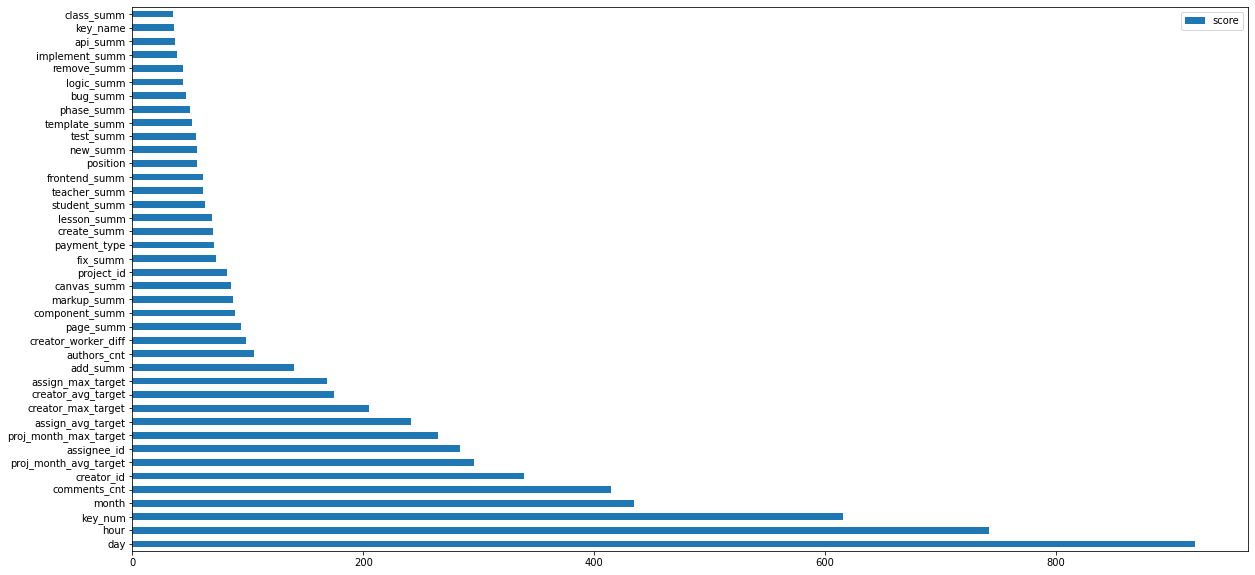

In [36]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)

data.nlargest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

# Предсказание на сайт

In [37]:
X_test = df_test.drop(['minute'], axis=1)
prediction = model.predict(X_test)
prediction = np.exp(prediction)
prediction = np.rint(prediction).astype('int64')
prediction

array([5504, 6050, 8538, ..., 2369, 2435, 4822])

In [38]:
df_solution = pd.read_csv('./data/sample_solution.csv')
df_solution.overall_worklogs = prediction
df_solution.head()

,id,overall_worklogs
0,675975,5504
1,675972,6050
2,675965,8538
3,675961,6811
4,675955,10056


In [39]:
df = pd.read_csv("./data/train/train_issues.csv")

orig_mean = int(df.overall_worklogs.mean())
sol_mean = int(df_solution.overall_worklogs.mean())
orig_mean, sol_mean

(17243, 7765)

In [42]:
def transform_dist(x):
    x = x + orig_mean - sol_mean
    return x

df_solution['overall_worklogs'] = df_solution['overall_worklogs'].apply(transform_dist)
df_solution.head()

,id,overall_worklogs
0,675975,14982
1,675972,15528
2,675965,18016
3,675961,16289
4,675955,19534


In [43]:
df_solution.to_csv('./solutions/d14_mean_no_comm.csv', index=False)

## Проверка предсказания

In [44]:
df_solution = pd.read_csv('./solutions/d14_mean_no_comm.csv')
df_solution.head()

,id,overall_worklogs
0,675975,14982
1,675972,15528
2,675965,18016
3,675961,16289
4,675955,19534
